In [1]:
import random
import json
import re
import os
import bz2
import spacy
nlp = spacy.load('en', disable=['ner', 'textcat'])

from textstat.textstat import textstat
import matplotlib.pyplot as plt

from nlgeval import compute_metrics

# Functions to read and prepare data

In [2]:
# extract complex and simple sentences and text category 
# from all data for one sentence in DBPedia dataset

def parseSentenceData(data):
    data = data.strip().split("\n\n")
    
    complexsentdata = data[0].strip().split("\n")
    complexid = int(complexsentdata[0].split("-")[1].strip())
    complexsent = complexsentdata[1].strip()

    cat = '' 
    mr_dict = {}
    # Collect all complex mrs
    for item in data[1:]:
        if re.match('COMPLEX-'+str(complexid)+':MR-[0-9]*\n', item):
            # print item
            mrdata = item.strip().split("\n")
            mrid = mrdata[0]
            mr = mrdata[1]
            if re.match('category=[a-zA-Z]* eid=Id[0-9]* size=[0-9]*', mr):
                cat = mr.strip().split(' ')[0].split('=')[1]
            mr_dict[mrid] = [mr, {}]
    
    simpsents = {}
    for item in data[1:]:
        if re.match('COMPLEX-'+str(complexid)+':MR-[0-9]*:SIMPLE-[0-9]*\n', item):
            
            mrid = ":".join(item.strip().split("\n")[0].split(":")[:2])

            sents = (" ".join(item.strip().split("\n")[1:])).strip()
            
            if sents not in simpsents:
                simpsents[sents] = 1

            if sents not in mr_dict[mrid][1]:
                mr_dict[mrid][1][sents] = 1

    return complexsent, simpsents, cat

In [3]:
# remove some frequent garbage from sentences 
def preprocessSentence(text):
    text = re.sub('-LRB-(.*?)-RRB-', '', text)
    text = re.sub('^\"', '', text)
    text = re.sub('\"$', '', text)
    return text

In [4]:
# Read DBPedia dataset
def readDBPediaData(compl_to_sim):
    filename = '../dataset/complexsimple.txt.bz2'
    with bz2.BZ2File(filename, "r") as content:         
        sentdata = []
        i = 0
        close_to_geo_categories = ['Monument', 'City', 'Airport', 'Building']

        for line in content:
            if len(sentdata) == 0:
                sentdata.append(line)
            else:
                if re.match('COMPLEX-[0-9]*\n', line):
                    complexsent, simpsents, cat = parseSentenceData("".join(sentdata))
                    simple_sen = simpsents.keys()[0]
                    
                    if (cat in close_to_geo_categories) and (len(simple_sen) > 0):
                        compl_to_sim[preprocessSentence(complexsent)] = preprocessSentence(simple_sen)
                    sentdata = [line]
                else:
                    sentdata.append(line)
    return compl_to_sim

In [5]:
# read Newsela dataset
def readNewselaData(compl_to_sim):
    with bz2.BZ2File('../dataset/clear_newsela.txt.bz2', "r") as content:         
        for line in content:
            texts = line.split('\t')

            if len(texts) != 2:
#                 print 'wrong line: ', line
                continue
            if (len(texts[0]) < 10) or (len(texts[1]) < 10):
#                 print 'empty line: ', line
                continue
                
            compl_to_sim[texts[0]] = texts[1]
    return compl_to_sim

In [6]:
# split data to train and test set
def splitTrainTest(compl_to_sim):
    train = {}
    test = {}

    for compl, sim in compl_to_sim.iteritems():
        try:
            sim_u = sim.encode('utf-8')
            compl_u = compl.encode('utf-8')
        except:
            continue
        r = random.random()
        if r < 0.8:
            train[compl] = sim
        else:
            test[compl] = sim
    return train, test

# Functions for baseline logic

In [7]:
# Some words does not make sense (or change sense) when used without dependent clause.
# For example, "part" in "part of the U.S.A." or "length" in "length of 4000".
# This function builds a clause required to save such information.

def getReasonableChunk(word, doc):
    chunk_words = []
    if word.pos_ == 'PROPN':
        try:
            chunks = list(x for x in doc.noun_chunks if x.root == word)[0]
            chunk_words.extend(list(x for x in chunks))
        except:
            print 'no chunk with root ' + word.text
    elif word.pos_ == 'NOUN':
        nummods = list(x for x in word.children if x.dep_ == 'nummod')
        chunk_words.append(word)
        chunk_words.extend(nummods)
        
        dets = list(x for x in word.children if x.dep_ == 'det')
        chunk_words.extend(dets)
        
        compunds = list(x for x in word.children if x.dep_ == 'compound')
        chunk_words.extend(compunds)
    else:
        chunk_words.append(word)

        
    prepositions = list(x for x in word.children if x.dep_ == 'prep')
    pobjects = []
    for prep in prepositions:
        pobjects = list(x for x in prep.children if x.dep_ == 'pobj')
        if len(pobjects) > 0:
            chunk_words.append(prep)
            for s in pobjects:
                chunk_words.extend(getReasonableChunk(s, doc))
                    
    return chunk_words

In [8]:
# convert list of lists of words to text (form readable sentences)
def wordsToSimpleText(sentence_words):
    text = ''
    for words in sentence_words:
        sentence_text = ''
        for word in words:
            sentence_text += word.text + ' '
            
        if len(sentence_text) > 0:
            sentence_text = sentence_text[0].upper() + sentence_text[1:]
            sentence_text += '. '
            
            text += sentence_text
    return text

In [9]:
# main baseline function
# build set of simple sentences based on each verb's subtree in a complex sentence
# input: spacy.doc with complex sentences
# output: text with one or more simple sentences

def subjVerbObjToSentence(sentence):
    verbs = list(x for x in sentence if x.pos_ == 'VERB')
    new_sentences = []
    for v in verbs:
        new_sent_words = [v]
        has_sence = False
        
        ouxilaries = list(x for x in v.children if (x.dep_ == 'aux') or (x.dep_ == 'auxpass'))
        new_sent_words.extend(ouxilaries)
        
        subjects = list(x for x in v.children if (x.dep_ == 'nsubj') or (x.dep_ == 'nsubjpass'))
        if len(subjects) > 0:
            has_sence = True
            for s in subjects:
                new_sent_words.extend(getReasonableChunk(s, sentence))

        attributes = list(x for x in v.children if (x.dep_ == 'attr'))
        if len(attributes) > 0:
            has_sence = True
            for s in attributes:
                new_sent_words.extend(getReasonableChunk(s, sentence))
                
        dobjects = list(x for x in v.children if x.dep_ == 'dobj')
        if len(dobjects) > 0:
            has_sence = True
            for s in dobjects:
                new_sent_words.extend(getReasonableChunk(s, sentence))
            
        prepositions = list(x for x in v.children if x.dep_ == 'prep')
        pobjects = []
        for prep in prepositions:
            pobjects = list(x for x in prep.children if x.dep_ == 'pobj')
            if len(pobjects) > 0:
                has_sence = True
                new_sent_words.append(prep)
                for s in pobjects:
                    new_sent_words.extend(getReasonableChunk(s, sentence))

        if v.dep_ == 'conj':
            subjects = list(x for x in v.head.children if (x.dep_ == 'nsubj') or (x.dep_ == 'nsubjpass'))
            if len(subjects) > 0:
                has_sence = True
                for s in subjects:
                    new_sent_words.extend(getReasonableChunk(s, sentence))
        
        new_sent_words = sorted(new_sent_words, key=lambda x: x.i)
        
        if has_sence == True:
            new_sentences.append(new_sent_words)
    
    simple_text = wordsToSimpleText(new_sentences)
    return simple_text


# Read and preprocess data

In [10]:
## main1 ##
compl_to_sim = {}
compl_to_sim = readNewselaData(compl_to_sim)
compl_to_sim = readDBPediaData(compl_to_sim)
train, test = splitTrainTest(compl_to_sim)
print len(train), len(test)

4931 1272


# Get some examples of baseline results

In [11]:
i = 0
for compl, sim in test.iteritems():
    i += 1
    if i > 20:
        break
    doc = nlp(compl.decode('utf-8'), disable=['ner', 'textcat'])
    simple_text = subjVerbObjToSentence(doc)

    print '\n\ncomplex sentence: '
    print doc.text
    print 'simple_text_given: '
    print sim
    print 'simple_text_generated: '
    print simple_text



complex sentence: 
Afonso Pena Airport , located in Sao Jose dos Pinhais , has a runway length of 2215.0 and a runway name of 11/29 .
simple_text_given: 
Afonso Pena International Airport runway length is 2215.0 . Afonso Pena International Airport is located in Sao Jose dos Pinhais . Afonso Pena International Airport has the runway name 11/29 .
simple_text_generated: 
Located in Sao Jose dos Pinhais . Afonso Pena Airport has a runway length of 2215.0 . 


complex sentence: 
"Plains Indians include Lakota , Blackfoot and Nez Perce ."
simple_text_given: 
"  Some of the most famous groups are the Lakota , Blackfoot and Nez Perce ."

simple_text_generated: 
Plains Indians include Lakota . 


complex sentence: 
With the capital of Cape Town , South Africa is the location of 11 Diagonal Street and has the ethnic groups of Asian South Africans and white South Africans .
simple_text_given: 
The address , 11 Diagonal Street is located in South Africa . In South Africa there is an ethnic group

# Get baseline results for all items in test set

In [12]:
## main2 ##
baseline_result = {}
for compl, sim in test.iteritems():
    doc = nlp(compl.decode('utf-8'), disable=['ner', 'textcat'])
    simple_text = subjVerbObjToSentence(doc)
    baseline_result[compl] = simple_text

no chunk with root Americans


# Calculate simplicity metrics

In [19]:
## main 3 ##
simplicity_metrics = {}

simplicity_metrics["lexicon_count"] = {}
simplicity_metrics["lexicon_count"]["compl"] = []
simplicity_metrics["lexicon_count"]["simple_gold"] = []
simplicity_metrics["lexicon_count"]["baseline"] = []

simplicity_metrics["flesch_reading_ease"] = {}
simplicity_metrics["flesch_reading_ease"]["compl"] = []
simplicity_metrics["flesch_reading_ease"]["simple_gold"] = []
simplicity_metrics["flesch_reading_ease"]["baseline"] = []

simplicity_metrics["flesch_kincaid"] = {}
simplicity_metrics["flesch_kincaid"]["compl"] = []
simplicity_metrics["flesch_kincaid"]["simple_gold"] = []
simplicity_metrics["flesch_kincaid"]["baseline"] = []

simplicity_metrics["automated_readability"] = {}
simplicity_metrics["automated_readability"]["compl"] = []
simplicity_metrics["automated_readability"]["simple_gold"] = []
simplicity_metrics["automated_readability"]["baseline"] = []

simplicity_metrics["difficult_words"] = {}
simplicity_metrics["difficult_words"]["compl"] = []
simplicity_metrics["difficult_words"]["simple_gold"] = []
simplicity_metrics["difficult_words"]["baseline"] = []

simplicity_metrics["linsear_write"] = {}
simplicity_metrics["linsear_write"]["compl"] = []
simplicity_metrics["linsear_write"]["simple_gold"] = []
simplicity_metrics["linsear_write"]["baseline"] = []

for compl, sim in test.iteritems():
    try:
        words_count = textstat.lexicon_count(compl)
        simplicity_metrics["lexicon_count"]["compl"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["compl"].append(textstat.flesch_reading_ease(compl))
        simplicity_metrics["flesch_kincaid"]["compl"].append(textstat.flesch_kincaid_grade(compl))
        simplicity_metrics["automated_readability"]["compl"].append(textstat.automated_readability_index(compl))
        simplicity_metrics["difficult_words"]["compl"].append(textstat.difficult_words(compl) / float(words_count))
        simplicity_metrics["linsear_write"]["compl"].append(textstat.linsear_write_formula(compl))
    except:
        print 'complex evaluation error'
        continue
    
    try:
        words_count = textstat.lexicon_count(sim)
        simplicity_metrics["lexicon_count"]["simple_gold"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["simple_gold"].append(textstat.flesch_reading_ease(sim))
        simplicity_metrics["flesch_kincaid"]["simple_gold"].append(textstat.flesch_kincaid_grade(sim))
        simplicity_metrics["automated_readability"]["simple_gold"].append(textstat.automated_readability_index(sim))
        simplicity_metrics["difficult_words"]["simple_gold"].append(textstat.difficult_words(sim) / float(words_count))
        simplicity_metrics["linsear_write"]["simple_gold"].append(textstat.linsear_write_formula(sim))
    except:
        print 'simple_gold evaluation error'
        continue
        
    try:
        words_count = textstat.lexicon_count(baseline_result[compl])
        simplicity_metrics["lexicon_count"]["baseline"].append(words_count)
        simplicity_metrics["flesch_reading_ease"]["baseline"].append(textstat.flesch_reading_ease(baseline_result[compl]))
        simplicity_metrics["flesch_kincaid"]["baseline"].append(textstat.flesch_kincaid_grade(baseline_result[compl]))
        simplicity_metrics["automated_readability"]["baseline"].append(textstat.automated_readability_index(baseline_result[compl]))
        simplicity_metrics["difficult_words"]["baseline"].append(textstat.difficult_words(baseline_result[compl]) / float(words_count))
        simplicity_metrics["linsear_write"]["baseline"].append(textstat.linsear_write_formula(baseline_result[compl]))
    except:
        print 'baseline evaluation error'
        continue



Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error
Error(ASyPW): Number of words are zero, cannot divide
baseline evaluation error


# Display simplicity metrics results

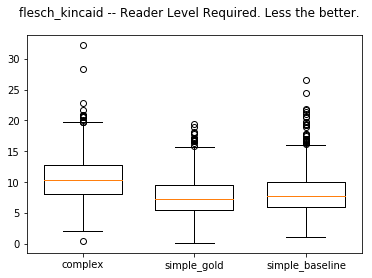

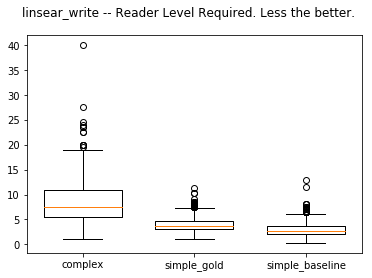

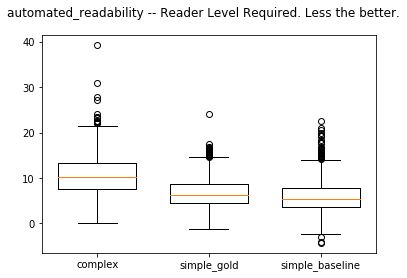

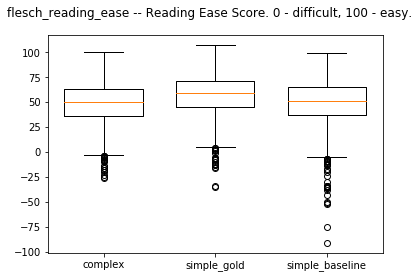

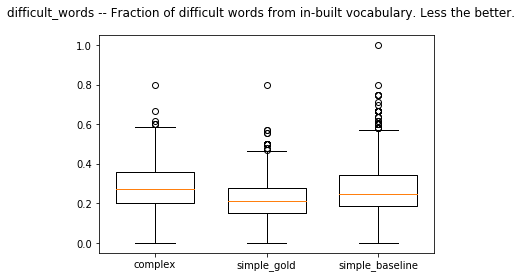

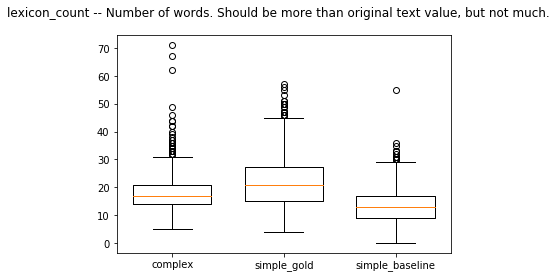

In [21]:
## main 4 ##

metrics_trends = {}
metrics_trends["lexicon_count"] = "Number of words. Should be more than original text value, but not much."
metrics_trends["flesch_reading_ease"] = "Reading Ease Score. 0 - difficult, 100 - easy."
metrics_trends["flesch_kincaid"] = "Reader Level Required. Less the better."
metrics_trends["automated_readability"] = "Reader Level Required. Less the better."
metrics_trends["difficult_words"] = "Fraction of difficult words from in-built vocabulary. Less the better."
metrics_trends["linsear_write"] = "Reader Level Required. Less the better."

for name, results in simplicity_metrics.iteritems():
    fig = plt.figure()
    titles = ["complex", "simple_gold", "simple_baseline"]
    data = [results["compl"], results["simple_gold"], results["baseline"]]
    plt.boxplot(data, positions = [1,2,3], widths = 0.7)
    plt.xticks([1,2,3], titles)
    fig.suptitle(name + ' -- ' + metrics_trends[name])


# Calculate similarity metrics

In [15]:
# save results to text files readable for metrics lib
with open("../dataset/test_simple.txt", "w") as h:
    for compl, sim in test.iteritems():
        if (len(sim) > 10) and (len(compl) > 10) and (len(baseline_result[compl]) > 10):
            sim = sim.replace("\n", "")
            sim += "\n"
            h.write(sim.encode('utf-8'))
                
with open("../dataset/test_complex.txt", "w") as r:
    for compl, sim in test.iteritems():
        if (len(sim) > 10) and (len(compl) > 10) and (len(baseline_result[compl]) > 10):
            compl = compl.replace("\n", "")
            compl += "\n"
            r.write(compl.encode('utf-8'))
            
with open("../dataset/test_baseline.txt", "w") as r:
    for compl, sim in test.iteritems():
        if (len(sim) > 10) and (len(compl) > 10) and (len(baseline_result[compl]) > 10):
            line = baseline_result[compl]
            line = line.replace("\n", "")
            line += "\n"
            r.write(line.encode('utf-8'))

In [16]:
# check number of lines
with open("../dataset/test_simple.txt", "r") as h:
    l = h.readlines()
    print len(l)
with open("../dataset/test_complex.txt", "r") as r:
    l = r.readlines()
    print len(l)
with open("../dataset/test_baseline.txt", "r") as r:
    l = r.readlines()
    print len(l)

1262
1262
1262


In [17]:
# calculate metrics for correspondence of generated sentence to gold-simple sentences
metrics_dict = compute_metrics(hypothesis="../dataset/test_baseline.txt",
                               references=["../dataset/test_simple.txt"])

Bleu_1: 0.716458
Bleu_2: 0.639674
Bleu_3: 0.572202
Bleu_4: 0.510325
METEOR: 0.384802
ROUGE_L: 0.693468
CIDEr: 2.374815
SkipThoughtsCosineSimilairty: 0.842285
EmbeddingAverageCosineSimilairty: 0.924820
VectorExtremaCosineSimilarity: 0.844452
GreedyMatchingScore: 0.949031
